In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def simulacija(
    dan_u_nedelji,
    lamda,
    sekundi_otvoren=50400,
    prosecno_vreme_zadrzavanja=1500,
    std_zadrzavanja=180,
):
    dolazak_sledeceg = 0
    potrebno_vreme_za_parking = []
    trenutak_uparkiranosti = []
    trenutni_kapacitet = []
    dostupnost = np.full(len(struktura_parkinga), 0)
    for trenutno_vreme in range(sekundi_otvoren):
        if trenutno_vreme == dolazak_sledeceg and trenutno_vreme < 49800:
            # print("Trenutno vreme", trenutno_vreme)
            cekanje_do_sledeceg = (
                np.round(
                    np.random.exponential(1 / lamda[dan_u_nedelji][trenutno_vreme])
                )
                + 1
            )
            # print("Cekanje do sledeceg", cekanje_do_sledeceg)
            dolazak_sledeceg = trenutno_vreme + cekanje_do_sledeceg
            # print("Dolazak sledeceg", dolazak_sledeceg)
            # print("\n\n")
            for idx, vrednost in enumerate(dostupnost):
                if vrednost == 0:
                    vreme_zadrzavanja = np.random.normal(
                        prosecno_vreme_zadrzavanja, std_zadrzavanja
                    )
                    dostupnost[idx] = trenutno_vreme + vreme_zadrzavanja
                    potrebno_vreme_za_parking.append(struktura_parkinga[idx])
                    trenutni_kapacitet.append(np.sum(dostupnost != 0))
                    trenutak_uparkiranosti.append(trenutno_vreme)
                    break
        dostupnost = np.where(dostupnost < trenutno_vreme, 0, dostupnost)
    #sns.lineplot(np.arange(len(lamda[dan_u_nedelji])), lamda[dan_u_nedelji])
    plt.show()
    return potrebno_vreme_za_parking, trenutak_uparkiranosti, trenutni_kapacitet

### Raspodela lamde po danima 

In [3]:
# Interpolacija vrednosti za lamdu
def lambda_distribution(lamda, len_open, time_interval):
    x = np.arange(len_open / time_interval)
    xp = np.linspace(0, len_open / time_interval, len(lamda))
    return np.interp(x, xp, lamda)


# Raspodela parametra lamda za Poasonovu raspodelu u toku dana
ponedeljak = np.array(
    [63, 97, 125, 150, 159, 154, 142, 152, 165, 201, 222, 203, 161, 107]
)
ponedeljak = lambda_distribution(ponedeljak, 14, 1 / 3600)

utorak = np.array([52, 74, 95, 112, 119, 123, 121, 127, 146, 177, 201, 188, 143, 95])
utorak = lambda_distribution(utorak, 14, 1 / 3600)

sreda = np.array([58, 73, 97, 109, 124, 121, 118, 120, 128, 149, 168, 161, 134, 87])
sreda = lambda_distribution(sreda, 14, 1 / 3600)

cetvrtak = np.array(
    [74, 102, 131, 147, 156, 151, 145, 143, 159, 182, 200, 186, 154, 97]
)
cetvrtak = lambda_distribution(cetvrtak, 14, 1 / 3600)

petak = np.array([59, 83, 106, 128, 141, 145, 142, 143, 152, 174, 196, 194, 155, 97])
petak = lambda_distribution(petak, 14, 1 / 3600)

subota = np.array([68, 109, 159, 197, 218, 212, 181, 158, 144, 155, 171, 162, 128, 85])
subota = lambda_distribution(subota, 14, 1 / 3600)

nedelja = np.array([62, 106, 150, 180, 193, 172, 153, 142, 160, 181, 183, 162, 114, 65])
nedelja = lambda_distribution(nedelja, 14, 1 / 3600)

In [4]:
broj_dolazaka_spic = 290
lamda = np.vstack([ponedeljak, utorak, sreda, cetvrtak, petak, subota, nedelja])
lamda = lamda / 3600

### Structure of the parking

<AxesSubplot:>

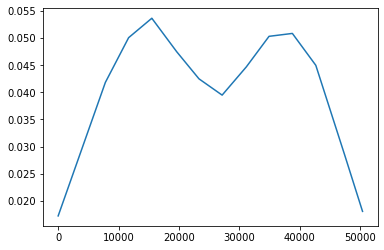

In [5]:
sns.lineplot(np.arange(len(lamda[6])), lamda[6])

In [6]:
struktura_parkinga = []
for i in range(120):
    # predjeni put do parking mesta / brzinom = 2.78
    t = (5 + i * 3) / 2.78
    struktura_parkinga.extend([t, t])

In [7]:
sekundi_otvoren = 14 * 60 * 60
dan_u_nedelji = 6
prosecno_vreme_zadrzavanja = 25 * 60
std_zadrzavanja = 3 * 60
days_of_the_week = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

labels = [
    "8:00",
    "9:00",
    "10:00",
    "11:00",
    "12:00",
    "13:00",
    "14:00",
    "15:00",
    "16:00",
    "17:00",
    "18:00",
    "19:00",
    "20:00",
    "21:00",
]

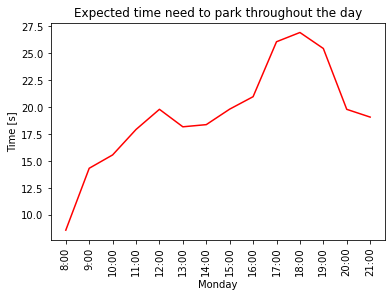

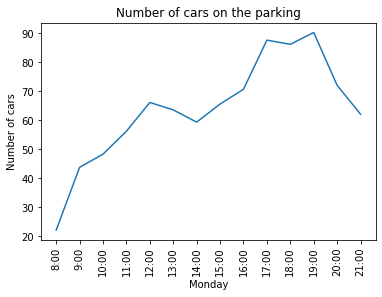

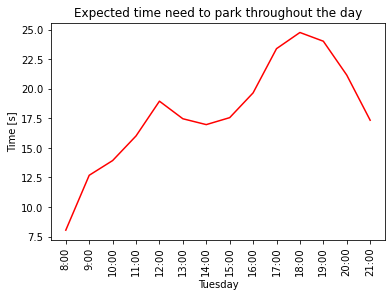

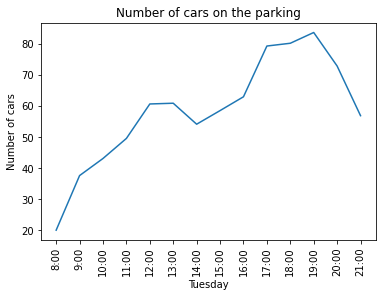

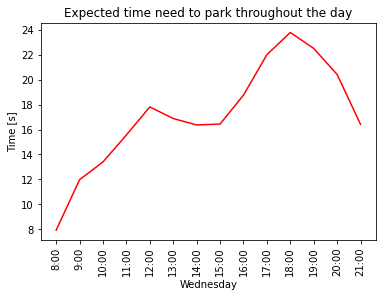

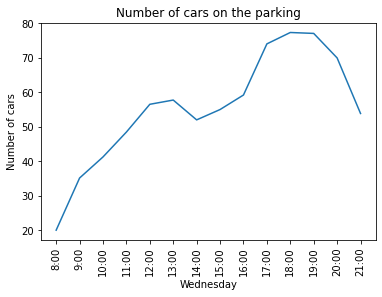

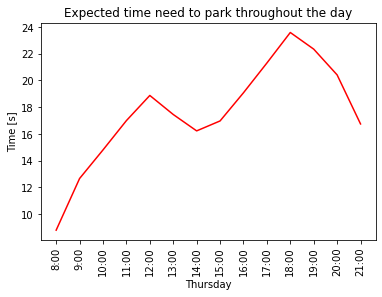

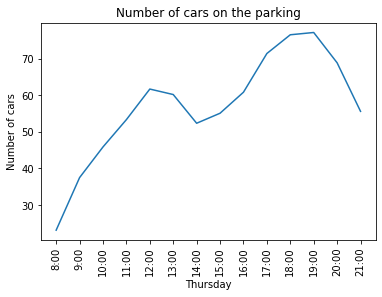

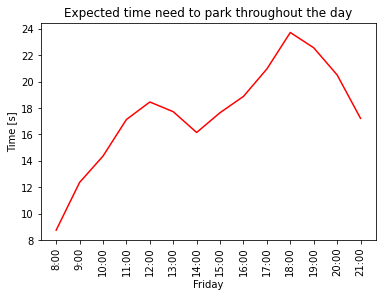

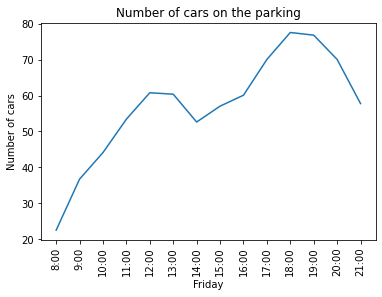

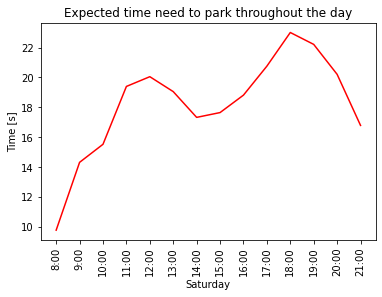

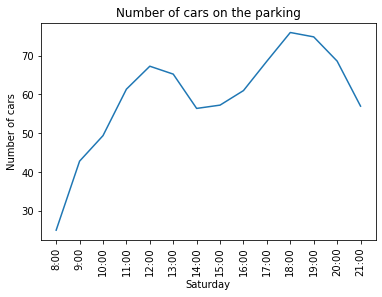

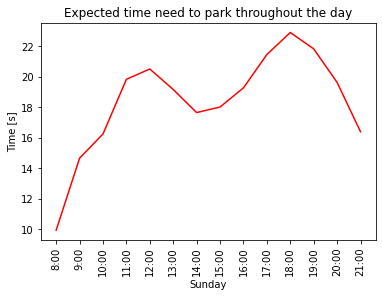

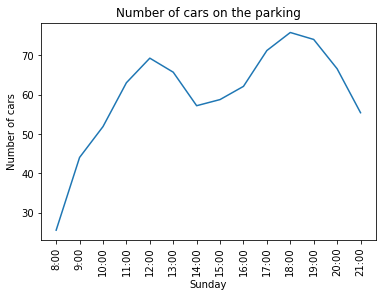

In [8]:
potrebno_vreme_niz = []
trenutak_niz = []
kapacitet_niz = []
resenja = {}

for dan in range(7):
    for i in range(1):
        potrebno_vreme, trenutak, kapacitet = simulacija(dan, lamda)
        potrebno_vreme_niz.extend(potrebno_vreme)
        trenutak_niz.extend(trenutak)
        kapacitet_niz.extend(kapacitet)

    df = pd.DataFrame(
        {
            "Potrebno vreme": potrebno_vreme_niz,
            "Trenutak": trenutak_niz,
            "Kapacitet": kapacitet_niz,
        }
    )
    df["Sat"] = (df["Trenutak"] / 3600).astype(int)

    df.groupby("Sat")["Potrebno vreme"].mean().plot(kind="line", c="r")
    #display(df.groupby("Sat")["Potrebno vreme"].mean())
    
    resenja[dan] = df.groupby("Sat")["Potrebno vreme"].mean()
    plt.xticks(ticks=np.arange(14), labels=labels)
    plt.ylabel("Time [s]")
    plt.xlabel(days_of_the_week[dan])
    plt.title("Expected time need to park throughout the day")
    plt.xticks(rotation=90)
    plt.show()
    
    
    df.groupby("Sat")["Kapacitet"].mean().plot(kind="line")
    plt.xticks(ticks=np.arange(14), labels=labels)
    plt.ylabel("Number of cars")
    plt.xlabel(days_of_the_week[dan])
    plt.title('Number of cars on the parking')
    plt.xticks(rotation=90)
    plt.show()